# Found faces and text in zip files of images

Takes a ZIP file of images and process them, Using zipfile library to read the provided file, the OpenCV library to detect faces, pytesseract to do optical character recognition for the text, and finally PIL to composite images together into contact sheets that contain the faces in every image of the zip file.

In [7]:
import zipfile
from PIL import Image
import pytesseract
import cv2 as cv
import numpy as np

In [8]:
def crop_imgs(img):
    ''' will return a list of faces from the original images '''
    crop_img = []
    face_cascade = cv.CascadeClassifier('haarcascade_frontalface_default.xml')
    nump_img = np.asarray(img)
    gray_img = cv.cvtColor(nump_img, cv.COLOR_BGR2GRAY)
    # A extra step using Gaussian Filter, take a look at the documentation:
    # https://docs.opencv.org/4.x/dc/dd3/tutorial_gausian_median_blur_bilateral_filter.html
    guas_img = cv.GaussianBlur(gray_img,(3,3),0) # change gray_img for guas_img
    faces = face_cascade.detectMultiScale(guas_img, scaleFactor= 1.24,minNeighbors=5, minSize=(30,30))

    # appending faces to the list to be return
    for x,y,w,h in faces:
        crop_img.append(img.crop((x, y, x+w, y+h)))    
    return crop_img

In [9]:
def cont_sheet(img_list: list):
    ''' Recieve a list of faces and return a contact sheet with those images '''
    some_faces = [face for face in img_list]
    # In case that that the image hasn't any face
    if len(some_faces) == 0:
        return 'But there were no faces in that file!'
    
    size_faces = [face.size for face in img_list]
    max_size = max(size_faces, key=lambda x: x)
    # Creating the image base for the conact sheet according to the ammount of faces
    if len(some_faces) < 6:
        contact_sheet = Image.new(some_faces[0].mode, (max_size[0]*5,max_size[1]))
    elif len(some_faces) < 11:
        contact_sheet = Image.new(some_faces[0].mode, (max_size[0]*5,max_size[1]*2))
    else:
        contact_sheet = Image.new(some_faces[0].mode, (max_size[0]*5,max_size[1]*3))
    x = 0
    y = 0
    # Appending every image to the contact sheet resizing everyone to the size of the bigger face
    for face in some_faces:
        face = face.resize(max_size)
        contact_sheet.paste(face,(x,y))
        if x+face.width == contact_sheet.width:
            x=0
            y = y + face.height
        else:
            x = x + face.width
    # This resize of the contact sheet is not necessary, but is useful to "reduce" resources
    contact_sheet = contact_sheet.resize((int(contact_sheet.width/2),int(contact_sheet.height/2)))

    return contact_sheet

In [10]:

def extract_zip(file):
    ''' 
    Will create a dict indexed by name of every file, it will put the file image, the text in that image,
    the faces, and the contact sheet created with those faces
    '''
    data_images = {}
    try:
        with zipfile.ZipFile(file,'r') as images:
            if images.infolist() == []:
                return 'This is an empty zip file' # Could be a zip file, but an empty one
            else:
                # Getting every name, image and text from the zip file
                names = [name.filename for name in images.infolist()]
                imgs = [Image.open(images.open(image)) for image in images.infolist()]
                texts = [pytesseract.image_to_string(Image.open(images.open(image)).convert('L')) 
                            for image in images.infolist()]
            # Creeating the dict indexed by name
            for i in range(len(images.infolist())):
                data_images[str(names[i])] = {'image':imgs[i], 'text':texts[i]}
            # Adding the faces as a list of faces and the contact sheet created with those faces 
            for k in data_images.keys():
                data_images[k]['faces'] = crop_imgs(data_images[k]['image'])
                data_images[k]['cont_sheet'] = cont_sheet(data_images[k]['faces'])
    except zipfile.BadZipFile as error: # In case that the provided file will not be a zip file
        return error
    return data_images

In [11]:
def answer(path,astr):
    ''' Recieve the path for the zip file and the string to be search in every file of that file
        Will return a message according the ammount of string founds in every file of the zip and 
        a contact sheet with the 'faces' in the files on the zip '''
    
    data = extract_zip(path)
    for k in data.items():
        if astr in data[k[0]]['text']:
            print('There are {} "{}" in {}'.format(data[k[0]]['text'].count(astr), astr,str(k[0])))
            display(data[k[0]]['cont_sheet'])
        else:
            print('There are no "{}" results in {}'.format(astr, str(k[0])))

There are 1 "Christopher" in a-0.png


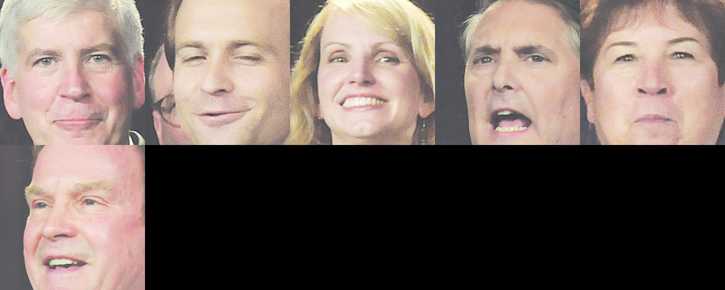

There are no "Christopher" results in a-1.png
There are no "Christopher" results in a-2.png
There are 1 "Christopher" in a-3.png


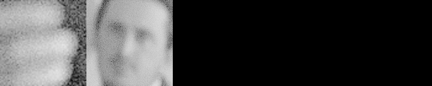

In [12]:
answer('small_img.zip', 'Christopher')

There are 1 "Mark" in a-0.png


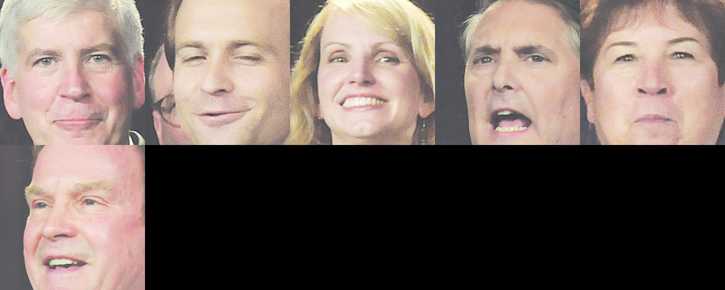

There are 3 "Mark" in a-1.png


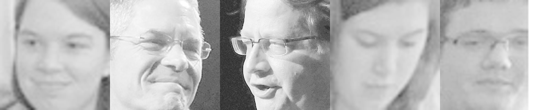

There are 2 "Mark" in a-10.png


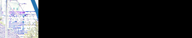

There are no "Mark" results in a-11.png
There are no "Mark" results in a-12.png
There are 1 "Mark" in a-13.png


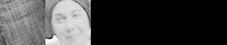

There are 1 "Mark" in a-2.png


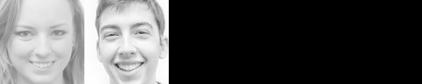

There are 4 "Mark" in a-3.png


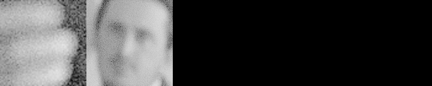

There are no "Mark" results in a-4.png
There are no "Mark" results in a-5.png
There are no "Mark" results in a-6.png
There are no "Mark" results in a-7.png
There are 1 "Mark" in a-8.png


'But there were no faces in that file!'

There are no "Mark" results in a-9.png


In [13]:
answer('images.zip', 'Mark')